# German Traffic Sign Recognition (GTSR)
We have downloaded and extracted the data in the '/storage' folder using **"1_download_dataset.ipynb"** notebook. Now let's do some Exploratory Data Analysis (EDA) on the downloaded data.

##### Import Packages

In [2]:
!pip install fastbook
from IPython.display import clear_output
from fastai.vision.all import *
import fastbook
import glob
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap
from fastai.vision.widgets import *
fastbook.setup_book()
clear_output()
%matplotlib inline
print("Imported and installed custom packages for this session")

Imported and installed custom packages for this session


In [2]:
# Define Input Path
inp_ds_path='/storage/gtsrb-german-traffic-sign'

### View Data

#### View csv files

In [3]:
# View Included CSV files
meta_df=pd.read_csv(inp_ds_path+'/Meta.csv')
meta_df.head()

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


In [4]:
test_df=pd.read_csv(inp_ds_path+'/Test.csv')
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [5]:
train_df=pd.read_csv(inp_ds_path+'/Train.csv')
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


#### Class and Image analysis

In [6]:
# Check total number of classes in Training data
np.sort(train_df['ClassId'].unique()), len(train_df['ClassId'].unique())

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]),
 43)

**There are 43 class in total**

In [7]:
# Get total number of images in Training and Testset
len(train_df),len(test_df)

(39209, 12630)

In [9]:
# Read Sign Names files
sign_names=pd.read_csv('sign_names.csv')

In [10]:
# Map Class Lable with Sign name and view distribution of images across each class
data_distribution=pd.DataFrame(train_df['ClassId'].value_counts())
data_distribution=data_distribution.reset_index()
data_distribution=data_distribution.rename(columns={'index':'ClassId','ClassId':'Count'})
data_distribution=data_distribution.merge(sign_names, how='inner', on='ClassId')
data_distribution['SignName_ClassId']=data_distribution['SignName']+' ['+data_distribution['ClassId'].map(str)+']'

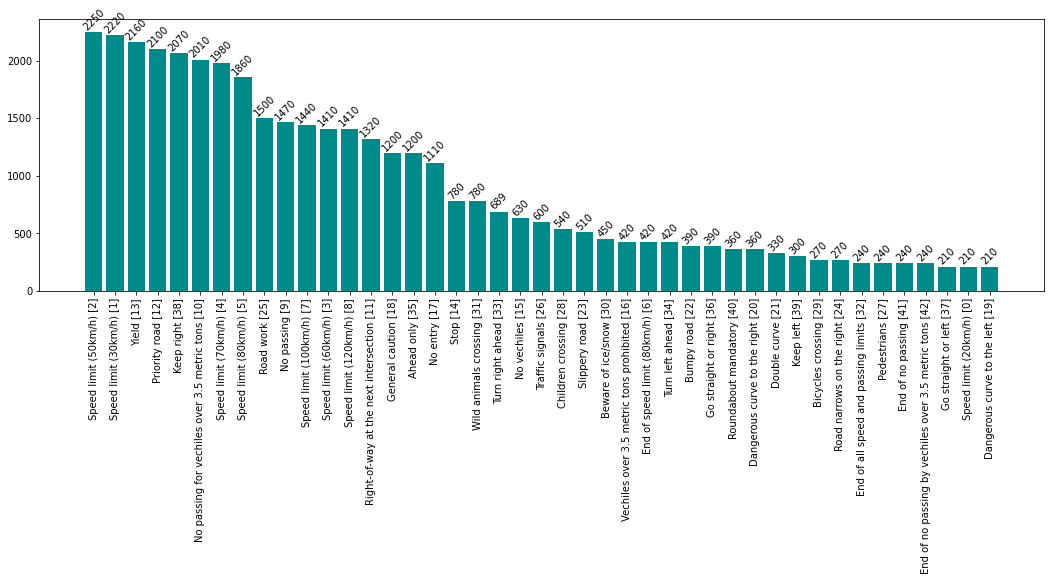

In [11]:
# Plot Distribution
fig, ax = plt.subplots(figsize=(18,5))
p = ax.bar('SignName_ClassId','Count',data=data_distribution, color='darkcyan')
plt.xticks(rotation=90)
plt.grid(False)
ax.bar_label(p,rotation=45)
fig.show()

This is a highly imbalanced data. 

**Note:** The Numbers in the square brackets are the Class ID's

#### View Images

Lets see how these Traffic signs looks like. We will be using the Meta Folder which contains standard images for eachm classes

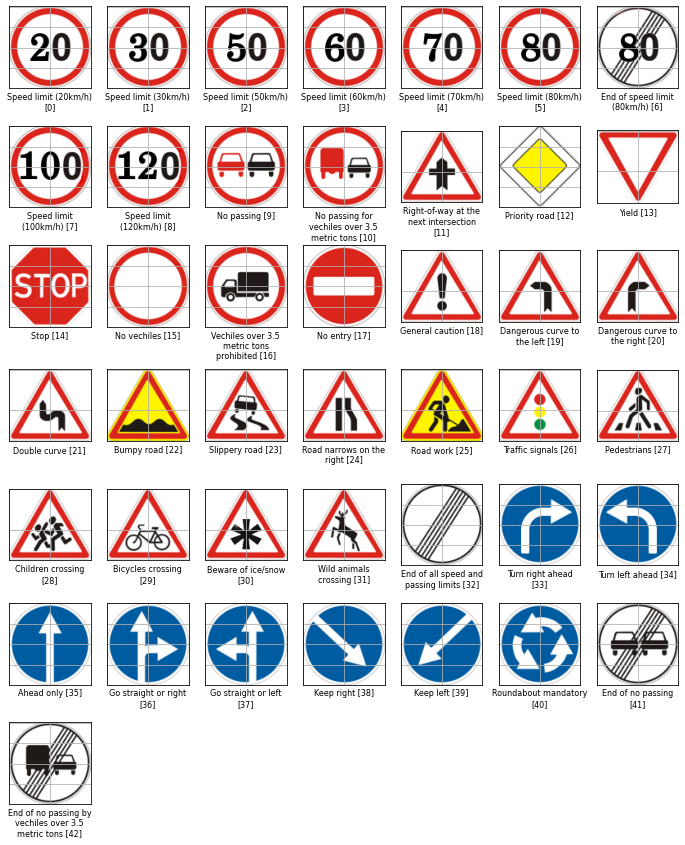

In [12]:
plt.figure(figsize=(12,15))
for i in range(0,43):
    plt.subplot(7,7,i+1)
    temp_path=inp_ds_path+'/Meta/'+str(i)+'.png'
    im=Image.open(temp_path)
    plt.imshow(im)
    plt.grid(b=None)
    # Print Class Label and remove ticks
    s_name=data_distribution[data_distribution['ClassId']==i]['SignName_ClassId'].values[0]
    s_name = '\n'.join(wrap(s_name, 20))
    plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
    plt.xlabel(s_name, fontsize = 8)

##### View Training data Images

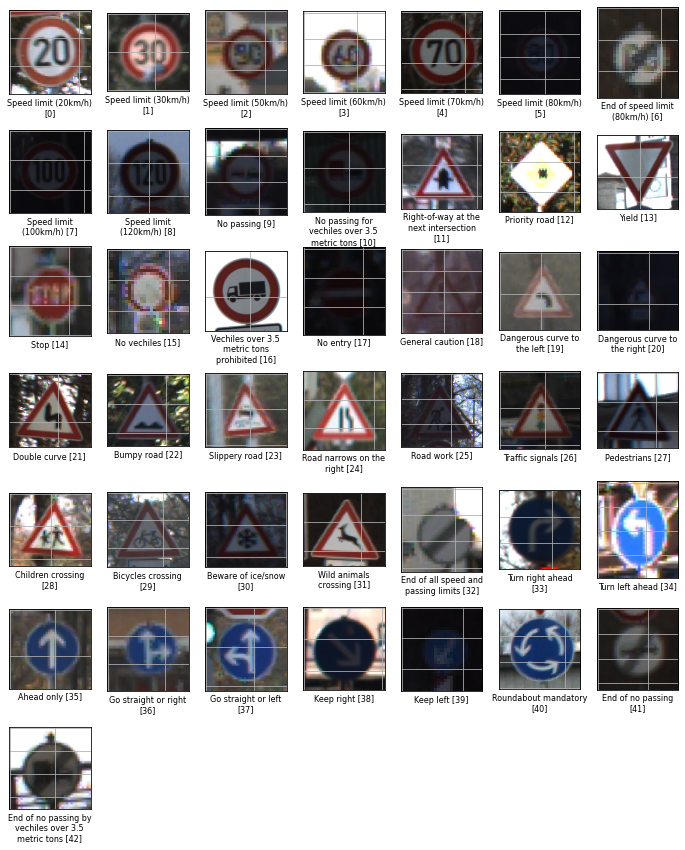

In [13]:
# View 1 image from each class of training set
plt.figure(figsize=(12,15))
for i in range(0,43):
    plt.subplot(7,7,i+1)
    temp_path=glob.glob(inp_ds_path+'/Train/'+str(i)+'/*.png')[0]
    im=Image.open(temp_path)
    plt.imshow(im)
    plt.grid(b=None)
    s_name=data_distribution[data_distribution['ClassId']==i]['SignName_ClassId'].values[0]
    s_name = '\n'.join(wrap(s_name, 20))
    # Print Class Label and remove ticks
    plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
    plt.xlabel(s_name, fontsize = 8)

##### View Test Set

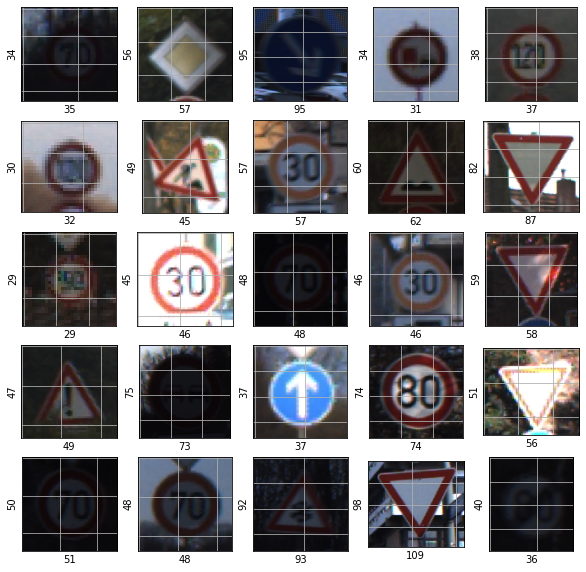

In [14]:
# View first 25 images of Test set along with image size
plt.figure(figsize=(10,10))
for i in range(1,26):
    plt.subplot(5,5,i)
    temp_path=glob.glob(inp_ds_path+'/'+'Test'+'/*.png')[i]
    im=Image.open(temp_path)
    plt.imshow(im)
    plt.grid(b=None)
    # Print height and width of image
    plt.xlabel(im.shape[1], fontsize = 10)#width of image
    plt.ylabel(im.shape[0], fontsize = 10)#height of image
    plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

### Train CNN Classifier

##### Create a DataBlock

In [15]:
# Create Data Loader
signs=DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=40),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.8),
    batch_tfms=aug_transforms(max_lighting=0.8,p_lighting=0.5 )
    )

In [15]:
#signs.summary(inp_ds_path+'/Train',show_batch=True)

##### Create Dataloader by providing path
**Note:** Here we will only by using data in "Train folder" to train out classifier.

In [16]:
dls=signs.dataloaders(inp_ds_path+'/Train')

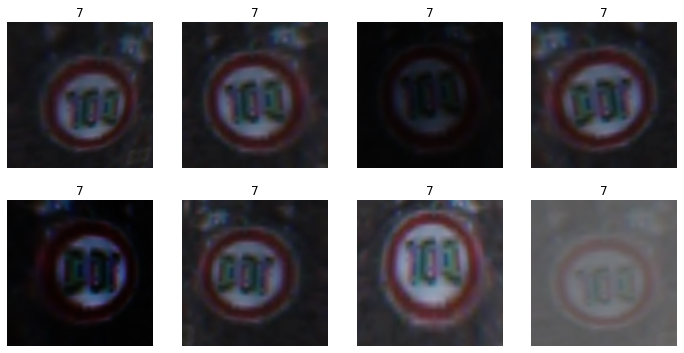

In [20]:
# View image in Training Set
dls.train.show_batch(max_n=8, nrows=2, unique=True)

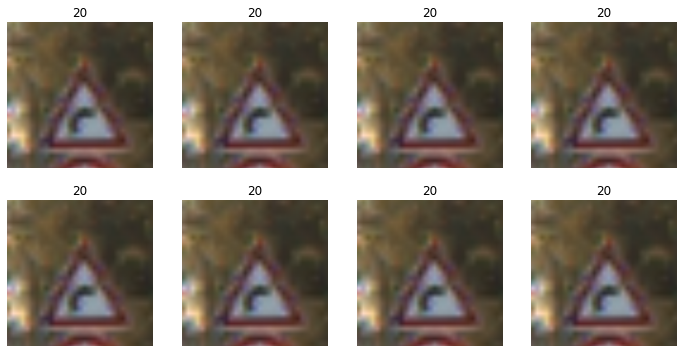

In [21]:
# View image in Validation set
dls.valid.show_batch(max_n=8, nrows=2, unique=True)

In [22]:
# View Classes in Training Data
dls.vocab, len(dls.vocab)

(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9'],
 43)

##### Create a CNN Classifier
we will be using resnet34 architecture to train this model with 15 epochs.

In [23]:
# Create a CNN Learner
learn = cnn_learner(dls, resnet34, metrics=error_rate)

/opt/conda/lib/python3.7/site-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

##### Clean Data

In [24]:
learn.fine_tune(15)

epoch,train_loss,valid_loss,error_rate,time
0,1.141647,0.450145,0.154317,07:17


epoch,train_loss,valid_loss,error_rate,time
0,0.284636,0.084474,0.029588,09:34
1,0.195768,0.047652,0.017727,09:34
2,0.125244,0.043075,0.013774,09:35
3,0.135941,0.033041,0.009183,09:34
4,0.097879,0.021104,0.006887,09:34
5,0.069337,0.013369,0.004464,09:35
6,0.053231,0.021601,0.004846,09:34
7,0.044366,0.010070,0.002168,09:35
8,0.049211,0.009265,0.003188,09:34
9,0.044970,0.002917,0.001275,09:34


#### Check confusion matrix

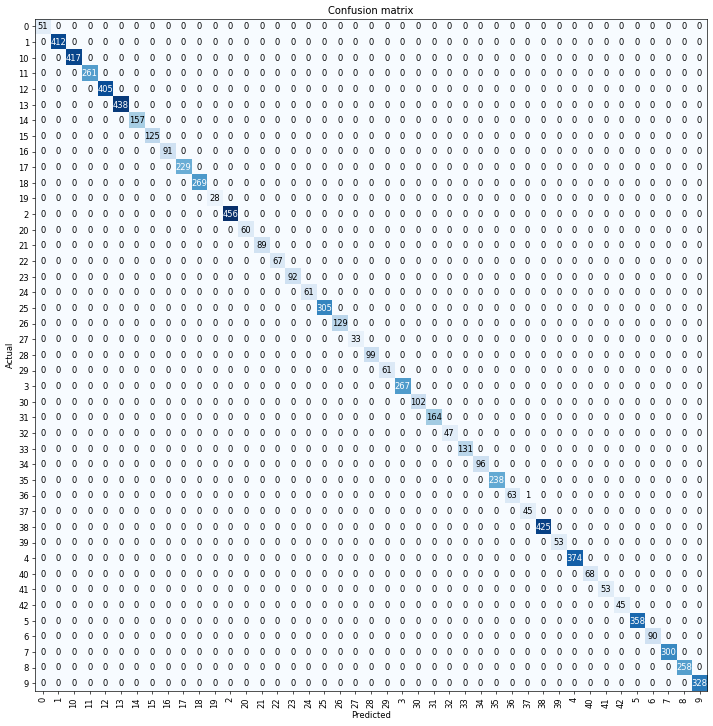

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

#### Get details of images where the classifier is least confident

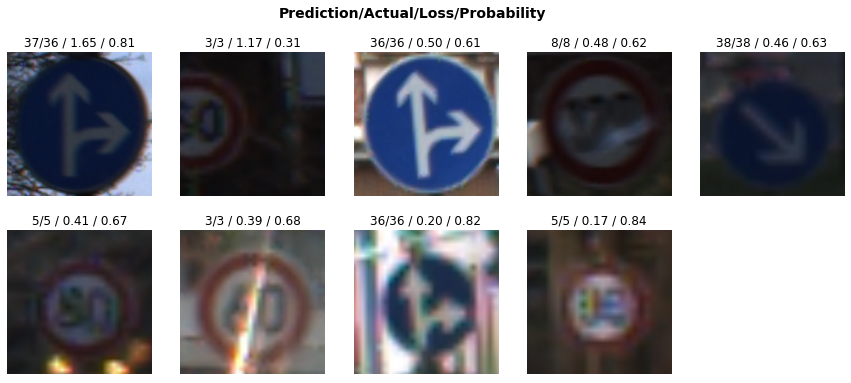

In [28]:
interp.plot_top_losses(10, nrows=2, largest=True)

In [29]:
interp.most_confused(min_val=4)

[]

#### Export Model
We will export this model and use this for classification of new traffic sign.

In [26]:
learn.export("model/"+'gtsr_resnet34_15e.pkl')